In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Loading dataset

In [ ]:
filepath = "/content/drive/MyDrive/CAS_with_claims_final.csv"
df = spark.read.csv(filepath, header= True, inferSchema = True)

In [ ]:
col_to_drop = ['_c0', 'X', 'Y','OBJECTID' ,'crashRoadSideRoad','intersection','pedestrian','temporarySpeedLimit','advisorySpeed',
              'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'crashSHDescription',
              'directionRoleDescription', 'flatHill', 'holiday', 'light', 'region',
              'roadCharacter', 'roadLane', 'roadSurface', 'streetLight', 'tlaName', 'meshblockId', 'areaUnitID', 'crashYear', 'tlaId',
              'trafficControl', 'crashSeverity' ]


df = df.drop(*col_to_drop)

df = df.na.drop()
cols_to_encode= ['weatherA', 'weatherB', 'urban']

Encoding categorical features into numerical

In [ ]:
# import the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

# numeric indexing for the strings (indexing starts from 0)
indexer = StringIndexer(inputCols= cols_to_encode, outputCols= ['weatherA_num', 'weatherB_num', 'urban_num'] ) 

# fit the indexer model and use it to transform the strings into numeric indices
indexed_df = indexer.fit(df).transform(df)

# one-hot-encoding the numeric indices
ohe = OneHotEncoder(inputCols= [ 'weatherA_num', 'weatherB_num', 'urban_num'], outputCols= ['weatherA_onehot', 'weatherB_onehot', 'urban_onehot'])

# fit the ohe model and use it to transform the numeric indices into ohe vectors
df1 = ohe.fit(indexed_df).transform(indexed_df)

df1= df1.drop(*cols_to_encode)
X = df1.drop('Claim_amount')


In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.mllib.evaluation import RegressionMetrics

tweedie = GeneralizedLinearRegression(family="tweedie", linkPower= 0, variancePower= 1 , labelCol="label")
gbr = GBTRegressor(featuresCol="features", maxIter=10)
dt = DecisionTreeRegressor(maxDepth= 10)
rf = RandomForestRegressor(numTrees=50, maxDepth=10)

In [ ]:
from pyspark.ml.feature import VectorAssembler

def my_VectorAssembler(input_cols, output_col, data):
  vectorAssembler = VectorAssembler(inputCols = input_cols, outputCol = output_col)
  v_df = vectorAssembler.transform(data)
  return v_df

def split_data(data):
  train, test= data.randomSplit([0.7, 0.3])
  return train, test

def transform(data, model):
  predictions = model.transform(data)
  return predictions

def get_meta_features(train, model):
  result= model.fit(train)
  return result

In [ ]:
#Vector assembler and train test split
v_df = my_VectorAssembler(X.columns, 'features', df1)
v_df = v_df.select(['features', 'Claim_amount'])
v_df = v_df.withColumnRenamed('Claim_amount', 'label')

train, test= split_data(v_df)
train1, train2= train.randomSplit([0.5, 0.5])

Defining function for stack

In [ ]:
def train_pipeline(train1, train2, model1, model2, final_model):
  #Tweedie
  reg1= get_meta_features(train1, model1)
  
  #GBR
  reg2= get_meta_features(train1, model2)
  
  #Getting base learner features
  #features from tweedie model
  predictions= transform(train2, reg1)
  train_new = predictions.withColumnRenamed('prediction', 'dt_pred')
  
  #features from gbr model
  predictions= transform(train2, reg2)
  train_gbr = predictions.withColumnRenamed('prediction', 'gbr_pred').drop('features','label')
  
  #concatenating feature vectors for final estimation
  train_new = train_new.withColumn("id", F.monotonically_increasing_id())
  train_gbr = train_gbr.withColumn("id", F.monotonically_increasing_id())
  train_df = train_new.join(train_gbr, on=['id'], how='left_outer')
  train_features = my_VectorAssembler( ['features','dt_pred', 'gbr_pred'] , 'meta_features', train_df)
  train_features = train_features.select(['meta_features', 'label'])
  train_features= train_features.withColumnRenamed('meta_features', 'features')
  
  #Final estimator Random forest
  reg3 = final_model.fit(train_features)
  result = reg3.transform(train_features)
  return result, reg1, reg2, reg3

In [ ]:
def transform_pipeline(data, model1, model2, final_model):
  #Tweedie
  predictions= transform(data, model1)
  train_new = predictions.withColumnRenamed('prediction', 'dt_pred')


  #GBR
  predictions = transform(data, model2)
  train_gbr = predictions.withColumnRenamed('prediction', 'gbr_pred').drop('features','label')

  #concatenating feature vectors for final estimation
  train_new = train_new.withColumn("id", F.monotonically_increasing_id())
  train_gbr = train_gbr.withColumn("id", F.monotonically_increasing_id())
  train_df = train_new.join(train_gbr, on=['id'], how='left_outer')
  train_features = my_VectorAssembler( ['features','dt_pred', 'gbr_pred'] , 'meta_features', train_df)
  train_features = train_features.select(['meta_features', 'label'])
  train_features= train_features.withColumnRenamed('meta_features', 'features')

  #Final estimator Random forest
  result = transform(train_features, final_model)
  return result

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

def evaluate(result):
  result= preds.withColumn('label', col('label').cast('double'))

  valuesAndPreds = result.select(['label', 'prediction'])
  # It needs to convert to RDD as the parameter of RegressionMetrics
  valuesAndPreds = valuesAndPreds.rdd.map(tuple)

  metrics = RegressionMetrics(valuesAndPreds)

  # Squared Error
  print("MSE = %s" % metrics.meanSquaredError)
  print("RMSE = %s" % metrics.rootMeanSquaredError)
  # Mean absolute error
  print("MAE = %s" % metrics.meanAbsoluteError)
    # R squared 
  print("R2 = %s" % metrics.r2)
  # Explained variance
  print("Explained variance = %s" % metrics.explainedVariance)

  
  pred_pandas = result.toPandas()
  plt.scatter('label', 'prediction', data = pred_pandas)
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')
  plt.show()

Stack 1

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 65547127044.90976
RMSE = 256021.7315872029
MAE = 98874.49811962605
R2 = 0.9552677801073711
Explained variance = 1546535600255.418


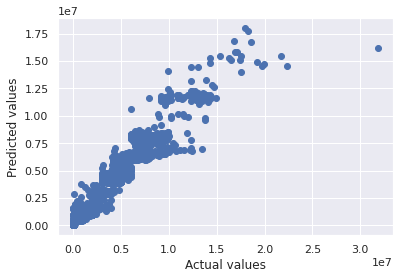

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(55,[0,1,15,19,25...|2315194.0|2553223.5922969747|
|(55,[0,2,3,12,15,...| 825802.0|491047.46182866546|
|(55,[0,2,3,12,15,...| 610944.0|478688.86067712225|
|(55,[0,2,6,12,15,...| 107602.0|496027.53128362854|
|(55,[0,2,11,15,27...|      0.0|               0.0|
|(55,[0,2,12,15,20...| 393831.0|  489767.898860433|
|(55,[0,3,5,12,15,...| 541022.0|  451517.705174474|
|(55,[0,3,6,12,15,...|1336965.0|1502871.8675913399|
|(55,[0,3,6,12,15,...|1721813.0|1502481.1396665415|
|(55,[0,3,6,15,27,...|      0.0|               0.0|
+--------------------+---------+------------------+
only showing top 10 rows



In [ ]:
result, dt_model1, gbr_model1, rf_model1 = train_pipeline(train1, train2, dt, gbr, rf)

preds = transform_pipeline(test, dt_model1, gbr_model1, rf_model1)
evaluate(preds)
preds.show(10)

Stack 2

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 64979443925.105125
RMSE = 254910.65871223417
MAE = 98907.61268853932
R2 = 0.9555007734167269
Explained variance = 1546535666679.315


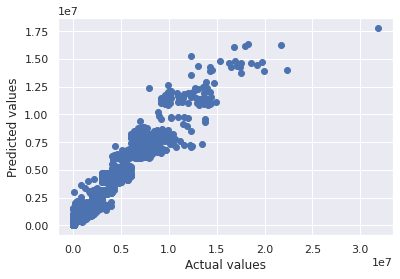

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(55,[0,1,15,19,25...|2315194.0| 2518981.519681841|
|(55,[0,2,3,12,15,...| 825802.0| 497459.7701300716|
|(55,[0,2,3,12,15,...| 610944.0|466182.38690153824|
|(55,[0,2,6,12,15,...| 107602.0|502787.59120953636|
|(55,[0,2,11,15,27...|      0.0|               0.0|
|(55,[0,2,12,15,20...| 393831.0|509743.80594858795|
|(55,[0,3,5,12,15,...| 541022.0| 427695.9910096292|
|(55,[0,3,6,12,15,...|1336965.0|1507515.9786048029|
|(55,[0,3,6,12,15,...|1721813.0|1501978.9238399009|
|(55,[0,3,6,15,27,...|      0.0| 10.07905138339921|
+--------------------+---------+------------------+
only showing top 10 rows



In [ ]:
result, tweedie, dtree, rf = train_pipeline(train1, train2,
                                            GeneralizedLinearRegression(family="tweedie", labelCol="label",maxIter= 200),
                                            DecisionTreeRegressor(maxDepth= 10),
                                            RandomForestRegressor(numTrees=100, maxDepth=10))

preds = transform_pipeline(test, tweedie, dtree, rf)
evaluate(preds)
preds.show(10)

Stack 3

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 62747052351.92655
RMSE = 250493.61738760243
MAE = 104662.97496598146
R2 = 0.9574245774670264
Explained variance = 1546535477530.0476


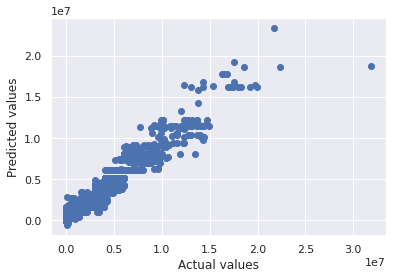

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(55,[0,1,15,19,25...|2315194.0| 2503493.335345082|
|(55,[0,2,3,12,15,...| 825802.0| 581989.3919716838|
|(55,[0,2,3,12,15,...| 610944.0| 578993.0705288313|
|(55,[0,2,6,12,15,...| 107602.0| 585766.4443772917|
|(55,[0,2,11,15,27...|      0.0|17317.099511672262|
|(55,[0,2,12,15,20...| 393831.0|  589098.461397223|
|(55,[0,3,5,12,15,...| 541022.0| 518356.9619365618|
|(55,[0,3,6,12,15,...|1336965.0|1505123.2221728242|
|(55,[0,3,6,12,15,...|1721813.0|1504702.1250992417|
|(55,[0,3,6,15,27,...|      0.0|   2452.1700221061|
+--------------------+---------+------------------+
only showing top 10 rows



In [ ]:
result, dtree, gbr, tweedie = train_pipeline(train1, train2,
                                            DecisionTreeRegressor(maxDepth= 10),
                                            GBTRegressor(featuresCol="features", maxIter=10),
                                            GeneralizedLinearRegression(family="tweedie", labelCol="label",maxIter= 200))

preds = transform_pipeline(test, dtree, gbr, tweedie)
evaluate(preds)
preds.show(10)